# Stroke Risk Prediction: A Comparison of Clinical and Lifestyle Risk Factors 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import average_precision_score

In [5]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv.xls')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 1. Business Understanding: 
Stroke is a serious and costly health outcome where early risk identification is a crucial step to improve prevention and patient monitoring. This project trains multiple predictive models to determine whether clinical risk factors or lifestyle-related factors are more effective at predicting stroke risk. Using supervised learning models the analysis compares predictive performance across both feature sets while accounting for the strong class imbalance within this specific data set. The models will be evaluated using recall, F1 score, and PR-AUC, with an emphasis on identifying stroke cases despite the class imbalance. 

### 2. Data Understanding:
The dataset contains demographic, lifestyle, and clinical health indicators for individuals, with stroke occurance as the target variable. 
- Approximately 5% of observations represent stroke cases, indicated a class imbalance. This imbalances makes accuracy an unreliable metric for evaluation. Therefore, the recall, F1-score,PR-AUC, and class weighted models will provide a better evaluation.
- BMI had a significant amount of missing values. Because BMI exhibits right skew and a lot of outliers, median imputation was done to reduce to sensitivity to the extreme outliers.
- BMI and average glucose level both exhibit a strong right skew, which can negatively impact the overall model performance. Log transformations were applied on these two variables.
Overall, there are three key challenges: missing values, skewed variables, and severe class imbalance.

This motivates the use of models that can address class imbalance and allow comparison across multiple algorithms and feature sets.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### 3. Data Preparation:
To prepare the data for modeling, several preprocessing steps were involved.
- Handling Missing Values: The BMI variable was handled by utilizing the median, in order to avoid bias with extreme values.
- Skewness: Log transformations were applied to BMI and average glucose to make the variance more stable. 
- Categorical variables:One-hot encoding was used to convert categorical variables into numerical form.
- Feature Engineering: Age groups and BMI categories were created in order to improve interpretability.

Two seperate feature groups were created to support model comparison: a clincal feature set representing medical risk factors and a lifestyle feature set representing behaviorial and demographic features. Each set will be used to train independent models to evaluate which features are more predictive. 

In [11]:
#Counting the number of missing values 
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
#Handling Missing Values 
df['bmi'].fillna(df['bmi'].median())

0       36.6
1       28.1
2       32.5
3       34.4
4       24.0
        ... 
5105    28.1
5106    40.0
5107    30.6
5108    25.6
5109    26.2
Name: bmi, Length: 5110, dtype: float64

In [13]:
#Replace all missing values in BMI column with the median value 
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

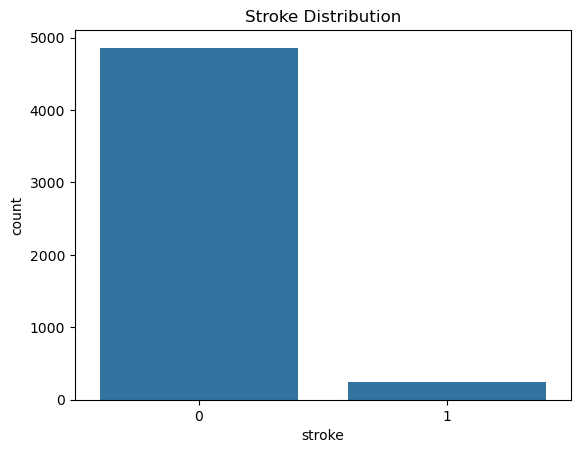

In [14]:
sns.countplot(x='stroke', data = df)
plt.title("Stroke Distribution")
plt.show()

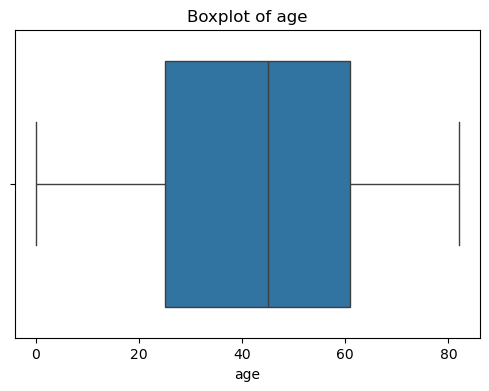

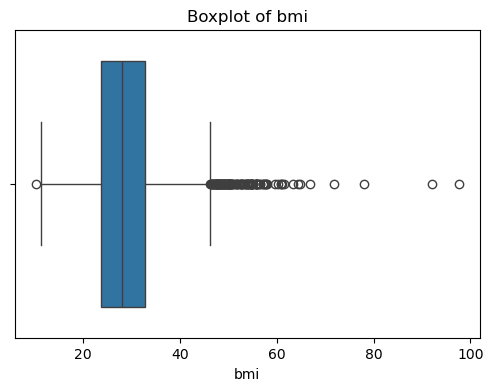

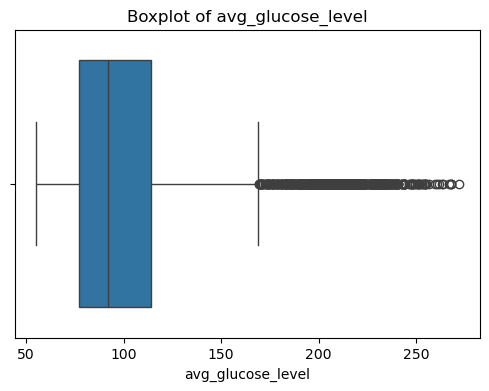

In [15]:
#Handling Outliers: Applying log transformation on extreme outliers to reduce variance
continous_cols = ['age', 'bmi', 'avg_glucose_level']
for col in continous_cols:
   plt.figure(figsize=(6,4))
   sns.boxplot(data=df, x=col)
   plt.title(f'Boxplot of {col}')
   plt.show()
#age seems to have no outliers
#BMI: significant right skew, values < 45
#Glucose: significantly right skewed 

In [16]:
#Calculating unbiased skewness of data within specified columns 
for col in ['bmi', 'avg_glucose_level']:
    skewness = df[col].skew()
    print(f"Skewness of {col}: {skewness:.2f}")

Skewness of bmi: 1.09
Skewness of avg_glucose_level: 1.57


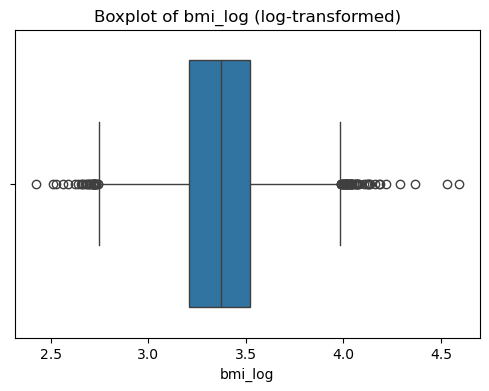

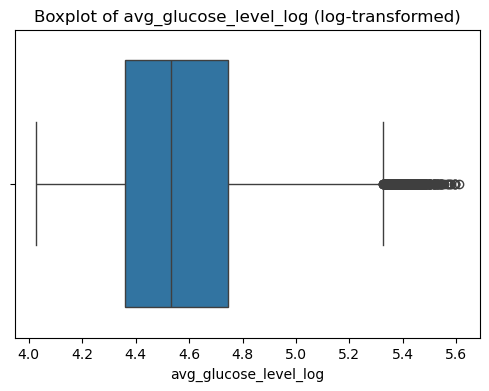

In [17]:
#Log transformation of selected variables 
df['bmi_log'] = np.log1p(df['bmi'])
df['avg_glucose_level_log'] = np.log1p(df['avg_glucose_level'])

for col in ['bmi_log', 'avg_glucose_level_log']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, data=df)
    plt.title(f"Boxplot of {col} (log-transformed)")
    plt.show()

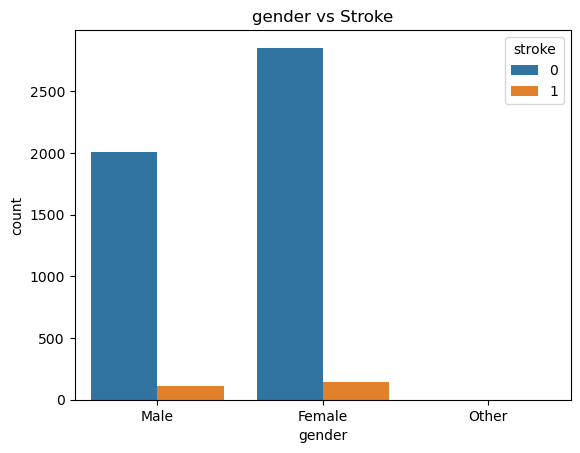

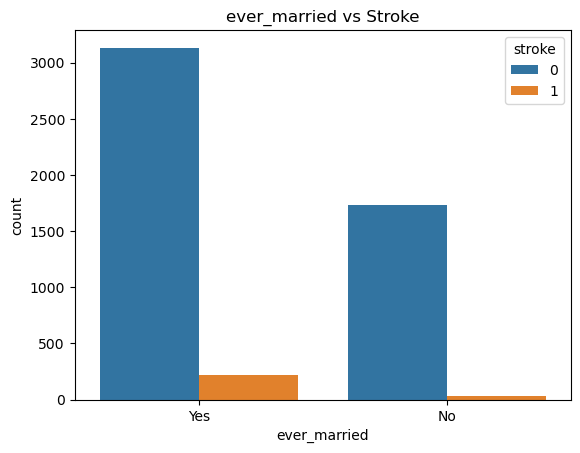

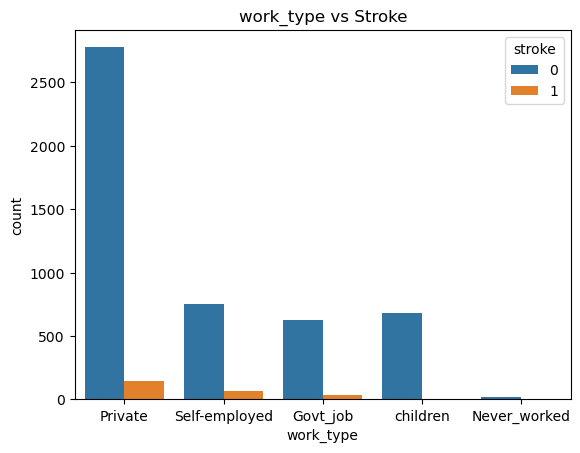

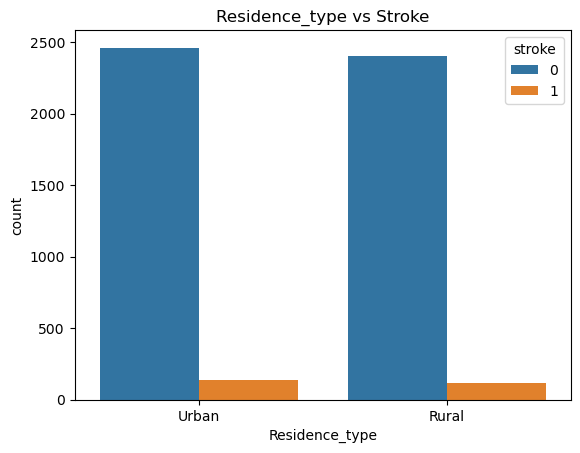

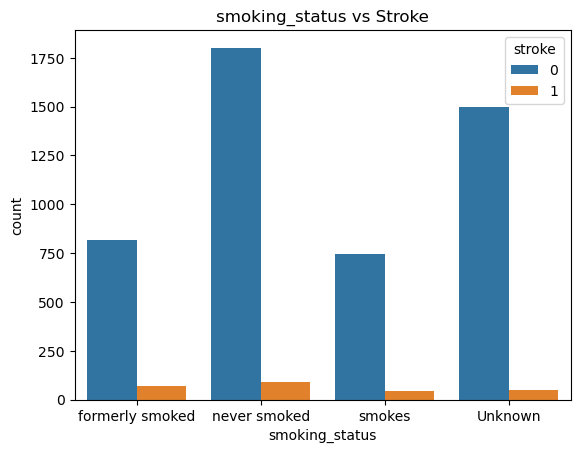

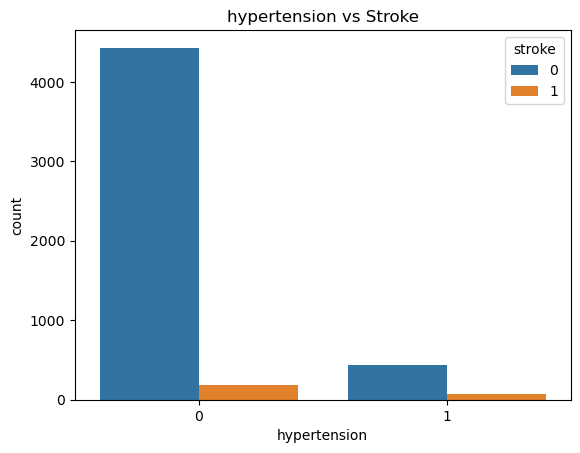

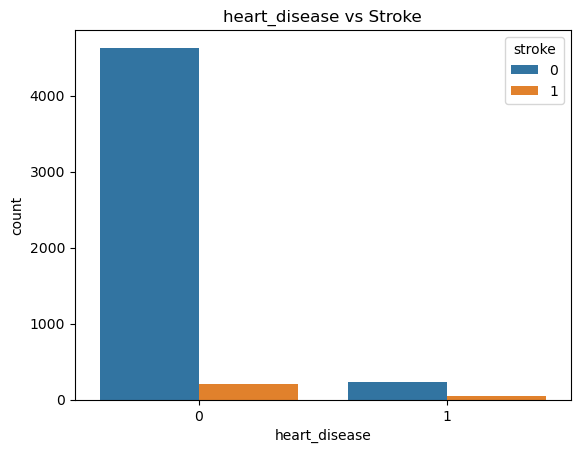

In [18]:
#Categorical Variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
for col in categorical_cols:
    sns.countplot(x=col, hue='stroke', data=df)
    plt.title(f"{col} vs Stroke")
    plt.show()

In [19]:
#Categorial variables x stroke percentage calculation 
for col in categorical_cols:
    s_proportions = df.groupby(col)['stroke'].mean()*100
    print(f"\nStroke percentage by {col}:\n{s_proportions}")


Stroke percentage by gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64

Stroke percentage by ever_married:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64

Stroke percentage by work_type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64

Stroke percentage by Residence_type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64

Stroke percentage by smoking_status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64

Stroke percentage by hypertension:
hypertension
0     3.967910
1    13.253012
Name: stroke, dtype: float64

Stroke percentage by heart_disease:
heart_disease
0     4.178734
1    17.028986
Name: stroke, dtype: float64


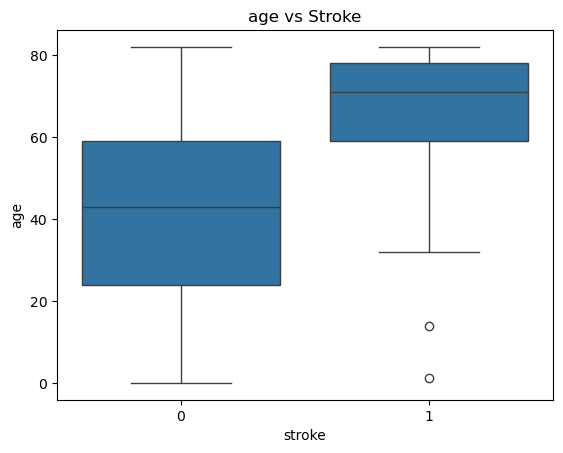

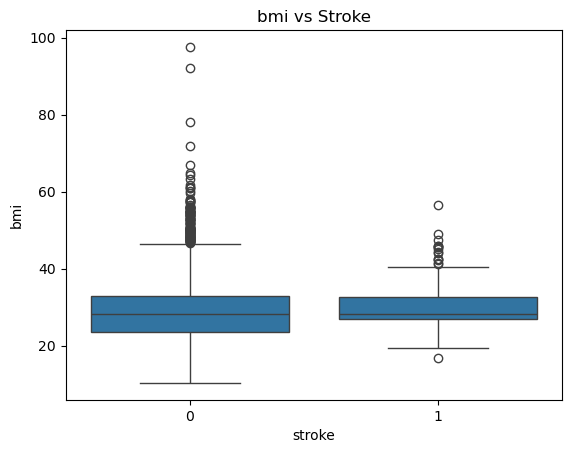

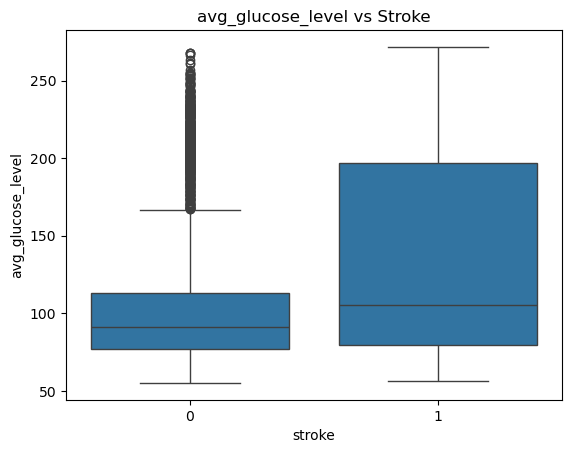

In [20]:
#Numerical Variables
numerical_cols = ['age', 'bmi', 'avg_glucose_level']
for col in numerical_cols:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f"{col} vs Stroke")
    plt.show()

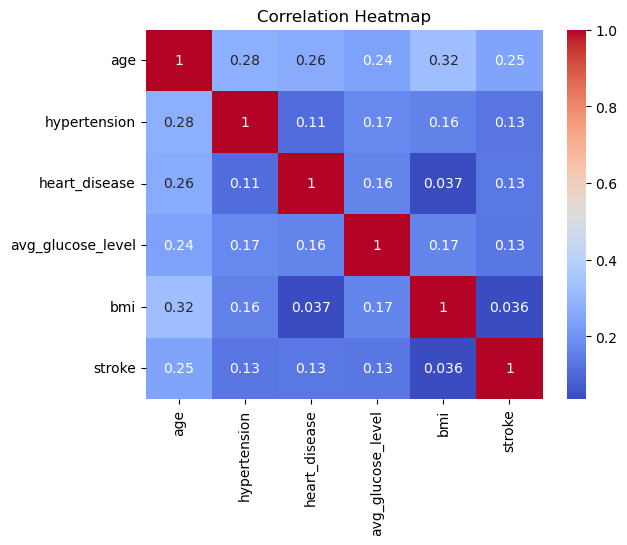

In [21]:
sns.heatmap(df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr(), annot = True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [22]:
#Feature Engineering: combining age groups and bmi into groups 
bins_age = [0,30,45,60,75,100]
labels_age = ['0-30', '31-45', '46-60', '61-75', '76+']
df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_log,avg_glucose_level_log,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,3.627004,5.436731,61-75
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,3.370738,5.314240,61-75
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,3.511545,4.672081,76+
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3.566712,5.148831,46-60
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,3.218876,5.165471,76+


In [23]:
bins_bmi = [0, 18.5, 24.9, 29.9, 100]
labels_bmi = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins = bins_bmi, labels = labels_bmi)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_log,avg_glucose_level_log,age_group,bmi_category
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,3.627004,5.436731,61-75,Obese
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,3.370738,5.314240,61-75,Overweight
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,3.511545,4.672081,76+,Obese
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3.566712,5.148831,46-60,Obese
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,3.218876,5.165471,76+,Normal


In [24]:
#Stroke percentage by Age Group
age_group_counts = df.groupby('age_group', observed = True)['stroke'].mean()*100

#Stroke percentage by BMI category
bmi_cat_counts = df.groupby('bmi_category', observed = True)['stroke'].mean()*100

print("\nStroke percentage by BMI Category:\n", bmi_cat_counts)


Stroke percentage by BMI Category:
 bmi_category
Underweight    0.286533
Normal         2.843217
Overweight     7.142857
Obese          5.104167
Name: stroke, dtype: float64


In [25]:
#Encode categorical variables
df_encoded = pd.get_dummies(df.drop('id', axis=1), drop_first=True)
print("\nEncoded columns:", df_encoded.columns)


Encoded columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'bmi_log', 'avg_glucose_level_log', 'gender_Male',
       'gender_Other', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'age_group_31-45', 'age_group_46-60', 'age_group_61-75',
       'age_group_76+', 'bmi_category_Normal', 'bmi_category_Overweight',
       'bmi_category_Obese'],
      dtype='object')


### 4. Modeling:
Four Independent models were trained:
1. Random Forest Baseline using all features
2. Weighted Logistic Regression Baseline using all features
3. Random Forest trained on clinical features only
4. Random Forest trained on lifestyle features only
Results: 
A baseline Random Forest Model was trained. Although the model achieved high accuracy (95%), it had a recall of 0.00 This means that it failed to identify any stroke cases. 
To address this issue, a weighted logistic regression model (class_weight = balanced) was trained to target any misclassification of stroke cases. This model improved the recall to 0.84, but produced a lower precision score of 0.13. This can be attributed to an increase in false positives. The model also produced a PR-AUC score of 0.26, indicated that the ranking of stroke risk did improve overall. 
Because stroke only accounts for 5% of the data, recall and PR-AUC were emphasized over accuracy because those metrics reflect better performance given the imbalanced dataset. 

### Model 1: Random Forest Model Baseline: ALL Features

In [28]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

In [29]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [30]:
#Model 1: Random Forest Baseline (ALL Features)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
#Predicting it
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



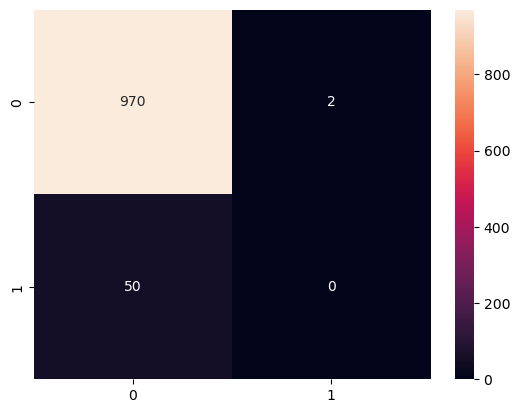

In [32]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
#Recall = 0 - failed to identify any stroke cases

### Model 2: Weighted Logistic Regression Baseline: ALL Features

In [34]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
X = df_encoded.drop("stroke", axis = 1)
y = df_encoded["stroke"]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
log_reg = LogisticRegression(class_weight = "balanced", penalty = "l2", solver = "liblinear", max_iter = 1000, random_state = 42)
#handling class imbalance and ridge (L2) regularization

In [36]:
#Model 2: Weighted Logisitc Regression Baseline (ALL Features)
log_reg.fit(X_train, y_train)
#Predictions with 0.5 threshold
y_pred_lr = log_reg.predict(X_test)
proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Weighted Logistic Regression: Baseline Model")
print(classification_report(y_test, y_pred_lr))


Weighted Logistic Regression: Baseline Model
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.84      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.78      0.53      1022
weighted avg       0.95      0.73      0.80      1022



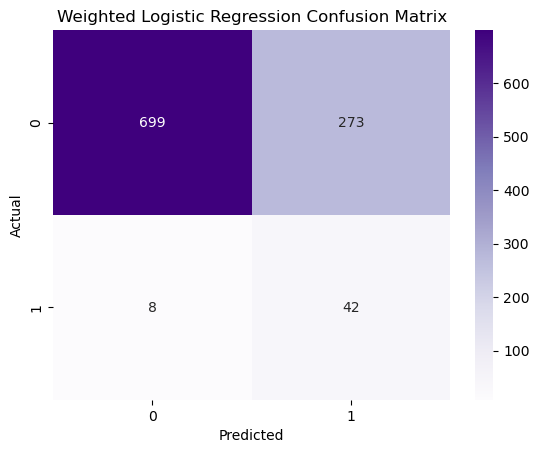

In [37]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Purples")
plt.title("Weighted Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
#PR-AUC
prec, rec, _ = precision_recall_curve(y_test, proba_lr)
pr_auc_lr = auc(rec, prec)
print("Logistic Regression PR-AUC:", round(pr_auc_lr, 3))

Logistic Regression PR-AUC: 0.26


### Evaluation Metrics
Because stroke represents approximately 5% of the data, accuracy is not reliable. An alternate solution would be to use recall and PR-AUC as a metric of model evaluation. Recall was emphasized to measure the model's ability to correctly identify stroke cases and PR-AUC was used as a threshold metric to evaluate how well the model ranked stroke cases compared to non-stroke cases. 

### Hypothesis:
A model trained using clinical risk factors (age, hypertension, heart disease, glucose, BMI) will better predict stroke risk than a model trained using lifestyle factors 

### Lifestyle and Clinical Feature Sets:
To evaluate whether medical or lifestyle factors are stronger predictors of stroke, the predictors were seperated into two distinct feature sets. 

Clinical Feature Set: includes variables that reflect medical risk: age, hypertension, heart disease, bmi (log-transformed), and average glucose level (log-transformed). 

Lifestyle Feature Set: includes demographic variables: gender, marital status, work type, residence type, smoking status. Because these variables are categorical, they were converted to one-hot encoded columns, and all encoded version were grouped together in the lifestyle model.

Threshold Tuning for Stroke Detection: Stroke consists of 5% of the data, therefore using default probabiliy (0.5) will cause model to under detect stroke cases. Used precision recall curve to evaluate different probability thresholds. The best value was selected so that the model can identify high-risk stroke patients. 

In [42]:
#Target:
y = df_encoded["stroke"].astype(int)

In [43]:
#Setting up clinical features: 
clinical_features = ["age", "hypertension", "heart_disease", "bmi_log", "avg_glucose_level_log"]

#safety check to ensure that that all variables included are not missing or incorrect
missing_clin = [c for c in clinical_features if c not in df_encoded]
if missing_clin:
    raise ValueError(f"Missing clinical columns in df_encoded: {missing_clin}")

X_clin = df_encoded[clinical_features].copy()

In [44]:
#setting up Lifestyle features:
lifestyle_features = [c for c in df_encoded.columns
                      if c.startswith("gender_")
                      or c.startswith("ever_marries_")
                      or c.startswith("work_type_")
                      or c.startswith("smoking_status_")]
X_life = df_encoded[lifestyle_features]

print("Clinical features:", clinical_features)
print("Lifestyle feature count:", len(lifestyle_features))

Clinical features: ['age', 'hypertension', 'heart_disease', 'bmi_log', 'avg_glucose_level_log']
Lifestyle feature count: 9


### Model 3: Clinical Features Random Forest

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop("stroke", axis = 1),
                                                    y, test_size = 0.2, stratify = y, random_state = 42)
Xc_train = X_train[clinical_features]
Xc_test = X_test[clinical_features]

X1_train = X_train[lifestyle_features]
X1_test = X_test[lifestyle_features]

print("Train Stroke Rate:", y_train.mean().round(4))
print("Test Stroke Rate:", y_test.mean().round(4))

Train Stroke Rate: 0.0487
Test Stroke Rate: 0.0489


### Grid Search/Hyperparameter Tuning
Want to improve the performance of the clinical random forest model. The goal of using GridSearch is to ensure that the model performs well across different splits of data. The PR-AUC and recall should improve. 
Results: 
- Precision (0.24): when the model predicts stroke, it's correct 24% of the time
- Recall (0.30): the model identifies with 30% of actual stroke cases
- F1-Score (0.27): balance of precision and recall, which is low because stroke in itself is rare
- Support : shows imbalance (50 stroke vs 972 no stroke)

In [48]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {"n_estimators": [200,400], "max_depth":[None, 10, 20], "min_samples_split": [2,5], "min_samples_leaf": [1,2]}
#using stat 5-fold cv for class imbalances
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

#Setting up grid search for clinical features
gs_rf = GridSearchCV(RandomForestClassifier(class_weight = "balanced", random_state = 42, n_jobs =-1),
                     param_grid, scoring = "average_precision", cv=cv, verbose = 1)
gs_rf.fit(Xc_train, y_train)
print("Hyperparameters:", gs_rf.best_params_)

y_pred_gs = gs_rf.predict(Xc_test)
proba_gs = gs_rf.predict_proba(Xc_test)[:, 1]
print("Clinical Random Forest Model (Grid Search) Classification Report")
print(classification_report(y_test, y_pred_gs))


pr_auc_gs = average_precision_score(y_test, proba_gs)
print("Clinical Random Forest Model PR-AUC (Grid Search):", round(pr_auc_gs, 3))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Clinical Random Forest Model (Grid Search) Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       972
           1       0.24      0.30      0.27        50

    accuracy                           0.92      1022
   macro avg       0.60      0.63      0.61      1022
weighted avg       0.93      0.92      0.92      1022

Clinical Random Forest Model PR-AUC (Grid Search): 0.233


In [49]:
#Threshold Tuning: what probability gives best balance between catching stroke and avoiding too many false alarms?
rf_model = RandomForestClassifier(n_estimators = 400, class_weight = "balanced", random_state = 42, n_jobs = -1)

rf_model.fit(Xc_train, y_train)
proba_c_rf = rf_model.predict_proba(Xc_test)[:,1]

In [50]:
prec, rec, thresh = precision_recall_curve(y_test, proba_c_rf)
f1 = 2*(prec*rec / (prec + rec + 1e-12))

best_idx = np.argmax(f1[:-1])
best_threshold = thresh[best_idx]
print("Best Threshold:", best_threshold)

Best Threshold: 0.13


Clinical Random Forest (Tuned Threshold)
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       972
           1       0.23      0.54      0.32        50

    accuracy                           0.89      1022
   macro avg       0.60      0.72      0.63      1022
weighted avg       0.94      0.89      0.91      1022



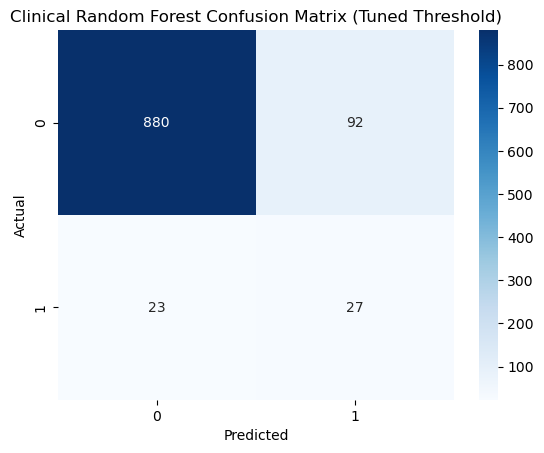

In [51]:
#applying new threshold to final predictions 
y_pred_c_rf_tuned = (proba_c_rf >= best_threshold).astype(int)

print("Clinical Random Forest (Tuned Threshold)")
print(classification_report(y_test, y_pred_c_rf_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_c_rf_tuned), annot=True, fmt="d", cmap="Blues")
plt.title("Clinical Random Forest Confusion Matrix (Tuned Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#Recall (stroke_) = 0.54, now catching approximately 54% of stroke cases compared to 0% before

In [52]:
#Specifically, ignoring thresholds set, does the model actually rank stroke patients higher then non stroke patients 

In [53]:
pr_auc_c_rf = average_precision_score(y_test, proba_c_rf)
print("Clinical Random Forest PR-AUC:", round(pr_auc_c_rf, 3))
#Baseline PR-AUC around 0.05, model PR-AUC = 0.195

Clinical Random Forest PR-AUC: 0.195


In [54]:
#training Lifestyle random forest 
rf_model_life = RandomForestClassifier(n_estimators = 400, class_weight = "balanced", random_state = 42, n_jobs =-1)
rf_model_life.fit(X1_train, y_train)

proba_1_rf = rf_model_life.predict_proba(X1_test)[:, 1]

### Model 4: Lifestyle Features Random Forest

In [56]:
#Threshold tuning lifestyle model
prec, rec, thresh = precision_recall_curve(y_test, proba_1_rf)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = np.argmax(f1[:-1])
best_threshold_1 = thresh[best_idx]
print("Best Lifestyle Threshold:", best_threshold_1)

#default works best 

Best Lifestyle Threshold: 0.4988478040869158


Lifestyle Random Forest (Tuned Threshold)
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       972
           1       0.06      0.50      0.11        50

    accuracy                           0.60      1022
   macro avg       0.51      0.55      0.43      1022
weighted avg       0.92      0.60      0.71      1022



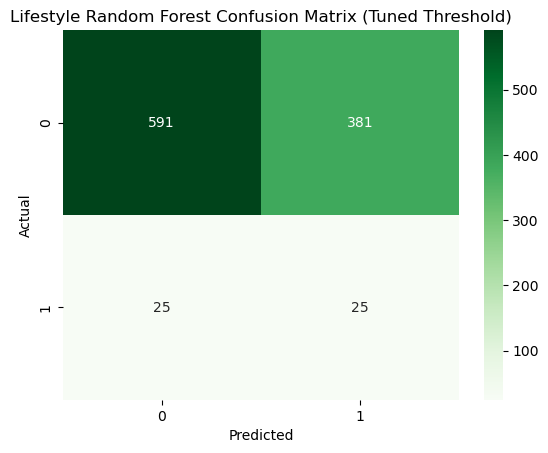

In [57]:
#applying new threshold to final predictions 
y_pred_1_rf_tuned = (proba_1_rf >= best_threshold_1).astype(int)

print("Lifestyle Random Forest (Tuned Threshold)")
print(classification_report(y_test, y_pred_1_rf_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_1_rf_tuned), annot=True, fmt="d", cmap="Greens")
plt.title("Lifestyle Random Forest Confusion Matrix (Tuned Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#Precision =0.06: produces a lot of false alarms
#Recall: -.5- catches about 50% pf actual stroke cases
#F1: 0.11: low because precision is low
#Accuracy: low because model trying to flag rare stroke cases instead of predicting 0 for everyone

### Lifestyle vs Clinical Features Set

In [59]:
#PR-AUC: Computing an overall measure of how well the model ranks stroke risk probabilities 
pr_auc_lifestyle = average_precision_score(y_test, proba_1_rf)
print("Lifestyle Random Forest PR-AUC:", round(pr_auc_lifestyle, 3))

pr_auc_clinical = average_precision_score(y_test, proba_gs)
y_pred_c_rf_tuned = (proba_gs >=0.13).astype(int)
print("Clinical Random Forest PR-AUC:", round(pr_auc_clinical, 3))

#comparing both models
print("Clinical Random Forest (Tuned Threshold)")
print(classification_report(y_test, y_pred_c_rf_tuned))
print("PR-AUC:", round(pr_auc_clinical, 3))
print ("-"*50)

print("Lifestyle Random Forest (Tuned Threshold)")
print(classification_report(y_test, y_pred_1_rf_tuned))
print("PR-AUC:", round(pr_auc_lifestyle, 3))
#PR-AUC: 0.195 > 0.059: clinical model ranks stroke risk more accurately
#Recall: both models catch about 50% of actual stroke cases
#Precision: 0.23>0.06, fewer false positives in clinical model

Lifestyle Random Forest PR-AUC: 0.059
Clinical Random Forest PR-AUC: 0.233
Clinical Random Forest (Tuned Threshold)
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       972
           1       0.10      0.82      0.18        50

    accuracy                           0.64      1022
   macro avg       0.54      0.72      0.47      1022
weighted avg       0.94      0.64      0.74      1022

PR-AUC: 0.233
--------------------------------------------------
Lifestyle Random Forest (Tuned Threshold)
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       972
           1       0.06      0.50      0.11        50

    accuracy                           0.60      1022
   macro avg       0.51      0.55      0.43      1022
weighted avg       0.92      0.60      0.71      1022

PR-AUC: 0.059


The clinical model underwent Grid Search hyperparameter tuning with stratified 5-fold cross validation, followed by threshold tuning using precision-recall curve. The probability threshold was adjusted from 0.5 (default) to 0.13 to maximize the F1 score and improve detection of stroke cases. 
At this threshold the clinical model produces a recall score of 0.82, precision of 0.10, and PR-AUC of 0.233, correctly identifying 82% of stroke cases. The Lifestyle model in comparison only achievs a recal score of 0.50, precision of 0.06, and  PR-AUC of 0.059, demonstrating weaker predictive power. 
Grid Search was applied only to the clinical feature set because the variables (age, BMI, average glucose, hypertension, heart disease) showed a strong predictive signal for stroke risk in the baseline models. Lifestyle variables had weaker predictive power, therefore hyperparameter tuning would not have changed the predictive power much. 

# Visualizations
These visualizations display the reliability of each model to stroke risk prediction. In the clinical model, age and average glucose level are the most influential factors. In contrast, the lifstyle model showed weaker correlation with stroke risk (work type and smoking status), insinuating that these variables provide limited predictive ability for stroke risk. This visual evidence further reinforces the results, demonstrating that clinical risk factors are more informative when determining stroke risk over lifestyle related factors. 

In [62]:
clinical_importance = pd.Series(gs_rf.best_estimator_.feature_importances_, index = clinical_features).sort_values(ascending = True)

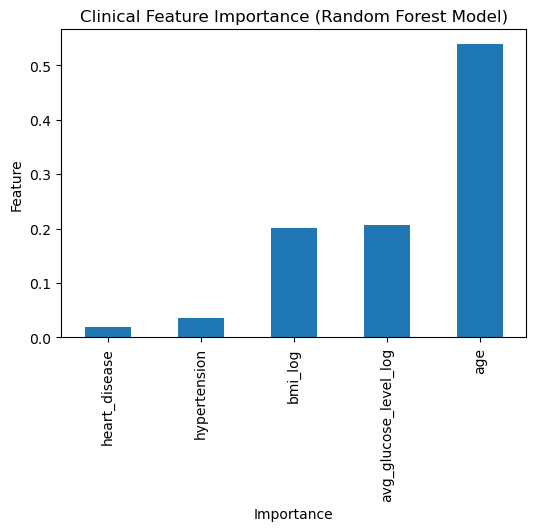

In [63]:
plt.figure(figsize = (6,4))
clinical_importance.plot(kind="bar")
plt.title("Clinical Feature Importance (Random Forest Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
#Model relies on age to determine stroke risk

In [64]:
lifestyle_importance = pd.Series(rf_model_life.feature_importances_, index = lifestyle_features).sort_values(ascending = True)

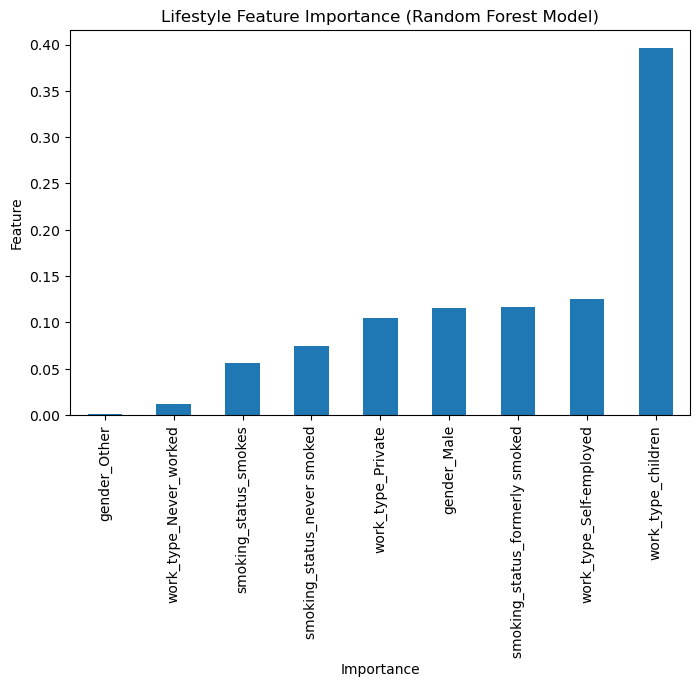

In [65]:
plt.figure(figsize = (8,5))
lifestyle_importance.plot(kind ="bar")
plt.title("Lifestyle Feature Importance (Random Forest Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
#Individuals who work and have children are at highest risk of a stroke

# Findings

Comparing all four models shows that models trained on clinical features outperform those trained on lifestyle features and baseline models. The clinical Random Forest model identified 82% of stroke cases (recall = 0.82), with a precision of 0.10 and PR-AUC of 0.233. In contrast the Lifestyle Random Forest model identifies only 50% of stroke cases (recall = 0.50), with a precision of 0.06 and a PR-AUC of 0.059. 
The Random Forest Baseline failed to identify any stroke cases (recall = 0.00) and the Weighted Logistic Regression Baseline captured 84% of stroke cases (recall = 0.84). However the precision score was low (0.13) compared to the clinical Random Forest model. 

This demonstrates that medical risk factors are more informative predictors of stroke. The clinical model outperforms the lifestyle model because it leverages variables with stronger stroke predictive power. These features provide measurable information that directly correlates with the likelihood of strokes occurring, whereas lifestyle variables such as gender, or worktype have weaker predictive power. The clinical model's performance is further enhanced by class weighting, which addresses the imbalance, and by hyperparameter and threshold tuning. These improved its ability to identify high-risk patients. As a result, the clinical model achieves higher recall and PR-AUC, allowing it to detect more stroke cases effectively. The lifestyle model captures fewer cases and produces many false positives. This demonstrates that medical risk factors are a strong predictor of stroke. 